# Weapon Damage

## Setting Up

In [1]:
import pandas as pd
import calendar
from weapon import max_shots, burst

weapon_stats = pd.read_csv("datasets/weapon_stats.csv")
ammo_stats = pd.read_csv("datasets/ammo_stats.csv")
weapon_firemodes = pd.read_csv("datasets/weapon_firemodes.csv")
damage_modifiers = pd.read_csv("datasets/damage_modifiers.csv")

## Data Merge

In [2]:
weapon_attacks = weapon_stats.merge(ammo_stats, on="weapon")
weapon_attacks = weapon_attacks.merge(weapon_firemodes, on="weapon")
weapon_attacks = weapon_attacks.sort_values(by=["weapon", "fire_mode"])
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32


## Chance to Hit

Soldiers start with an Accuracy value between 40 and 70, giving an average of 55.

To get the change of hit this should by applied to the weapon accuracy. Just multiply them as proportions. So an average of 55 to a weapon of Accuracy 90 means 0.55 * 0.9 = 0.495 chance of hit.

In [3]:
weapon_attacks["chance_to_hit"] = weapon_attacks.apply(lambda x: x["accuracy"] / 100 * 0.55, axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760


## Derived Damage

In [4]:
# weapon_attacks = weapon_attacks.apply(burst, axis=1)
weapon_attacks["burst"] = weapon_attacks.apply(burst, axis=1)
weapon_attacks["expected_damage"] = weapon_attacks.apply(lambda x: x["damage"] * x["chance_to_hit"], axis=1)
weapon_attacks["turn_max_shots"] = weapon_attacks.apply(max_shots, axis=1)
weapon_attacks["turns_to_reload"] = weapon_attacks.apply(lambda x: x["capacity"] / x["turn_max_shots"], axis=1)
weapon_attacks["turn_damage_max"] = weapon_attacks.apply(lambda x: x["turn_max_shots"] * x["damage"], axis=1)
weapon_attacks["turn_damage_expected"] = weapon_attacks.apply(lambda x: x["turn_damage_max"] * x["chance_to_hit"], axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,burst,expected_damage,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575,1,32.175,1,1.000000,90,32.175
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510,1,18.942,1,14.000000,42,18.942
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510,1,19.844,1,14.000000,44,19.844
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510,1,21.648,1,14.000000,48,21.648
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760,3,7.392,6,2.333333,252,44.352


## Damage Ranking

### Most Damaging Weapon

In a single turn, shooting as much as possible, which weapon does the most damage.

This takes into account reloading.

In [5]:
most_damaging_weapon = weapon_attacks[["weapon", "turn_damage_expected"]]
most_damaging_weapon = most_damaging_weapon.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon = most_damaging_weapon.groupby("weapon").max()
most_damaging_weapon = most_damaging_weapon.sort_values(by=["turn_damage"])
most_damaging_weapon

,turn_damage
weapon,
grenade,17.8750
proximity_grenade,25.0250
alien_grenade,32.1750
high_explosive,39.3250
rifle,39.6000
pistol,42.9000
auto_cannon,50.6880
rocket_turret,53.7625
cannon_turret,59.4000


Text(0, 0.5, 'Damage')

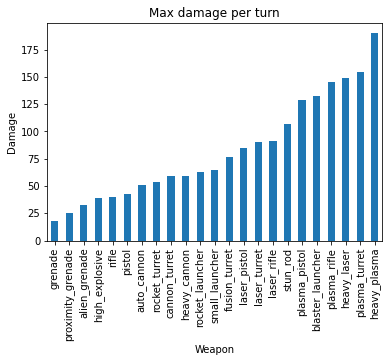

In [6]:
ax = most_damaging_weapon.plot.bar(title="Max damage per turn", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

### Most Damaging Snapshot

In [7]:
most_damaging_weapon_snap = weapon_attacks[weapon_attacks["fire_mode"] == "snapshot"]
most_damaging_weapon_snap = most_damaging_weapon_snap[["weapon", "turn_damage_expected"]]
most_damaging_weapon_snap = most_damaging_weapon_snap.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_snap = most_damaging_weapon_snap.groupby("weapon").max()
most_damaging_weapon_snap = most_damaging_weapon_snap.sort_values(by=["turn_damage"])
most_damaging_weapon_snap

,turn_damage
weapon,
rocket_launcher,30.2500
rifle,39.6000
pistol,42.9000
auto_cannon,44.3520
laser_pistol,50.6000
laser_turret,51.4250
rocket_turret,51.4250
plasma_pistol,55.7700
cannon_turret,59.4000


Text(0, 0.5, 'Damage')

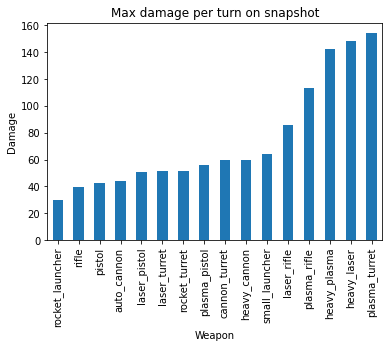

In [8]:
ax = most_damaging_weapon_snap.plot.bar(title="Max damage per turn on snapshot", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

### Most Damaging Aimed

In [9]:
most_damaging_weapon_aim = weapon_attacks[weapon_attacks["fire_mode"] == "aimed"]
most_damaging_weapon_aim = most_damaging_weapon_aim[["weapon", "turn_damage_expected"]]
most_damaging_weapon_aim = most_damaging_weapon_aim.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_aim = most_damaging_weapon_aim.groupby("weapon").max()
most_damaging_weapon_aim = most_damaging_weapon_aim.sort_values(by=["turn_damage"])
most_damaging_weapon_aim

,turn_damage
weapon,
laser_pistol,17.2040
rifle,18.1500
auto_cannon,21.6480
plasma_pistol,24.3100
cannon_turret,29.7000
heavy_cannon,29.7000
pistol,33.4620
plasma_rifle,44.0000
rocket_turret,53.7625


Text(0, 0.5, 'Damage')

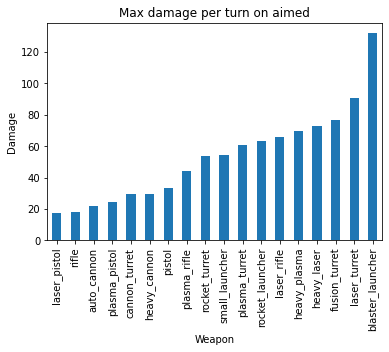

In [10]:
ax = most_damaging_weapon_aim.plot.bar(title="Max damage per turn on aimed", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

### Most Damaging Auto

In [11]:
most_damaging_weapon_auto = weapon_attacks[weapon_attacks["fire_mode"] == "auto"]
most_damaging_weapon_auto = most_damaging_weapon_auto[["weapon", "turn_damage_expected"]]
most_damaging_weapon_auto = most_damaging_weapon_auto.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_auto = most_damaging_weapon_auto.groupby("weapon").max()
most_damaging_weapon_auto = most_damaging_weapon_auto.sort_values(by=["turn_damage"])
most_damaging_weapon_auto

,turn_damage
weapon,
rifle,34.650
auto_cannon,50.688
laser_pistol,85.008
laser_rifle,91.080
plasma_pistol,128.700
plasma_rifle,145.200
heavy_plasma,189.750


Text(0, 0.5, 'Damage')

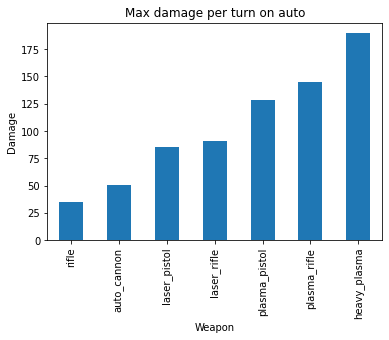

In [12]:
ax = most_damaging_weapon_auto.plot.bar(title="Max damage per turn on auto", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

### Most Damaging Grenade

In [13]:
most_damaging_weapon_grenade = weapon_attacks[weapon_attacks["fire_mode"] == "grenade"]
most_damaging_weapon_grenade = most_damaging_weapon_grenade[["weapon", "turn_damage_expected"]]
most_damaging_weapon_grenade = most_damaging_weapon_grenade.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_grenade = most_damaging_weapon_grenade.set_index(["weapon"])
most_damaging_weapon_grenade = most_damaging_weapon_grenade.sort_values(by=["turn_damage"])
most_damaging_weapon_grenade

,turn_damage
weapon,
grenade,17.875
proximity_grenade,25.025
alien_grenade,32.175
high_explosive,39.325


Text(0, 0.5, 'Damage')

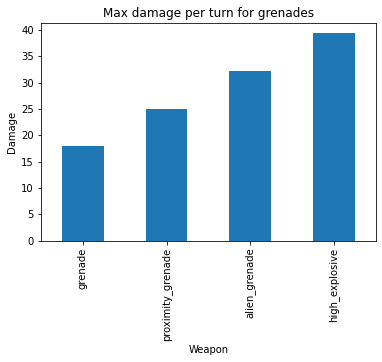

In [14]:
ax = most_damaging_weapon_grenade.plot.bar(title="Max damage per turn for grenades", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")